# Football Events and Game Information

# Question to answer
What is the value of a shot? Or what is the probability of a shot being a goal given its location, shooter, league, assist method, gamestate, number of players on the pitch, time - known as expected goals (xG) models [Binary classification, Sara ]


imports and initialization

In [1]:
import zipfile
import numpy as np 
import scipy as sp 
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import pandas as pd 
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
%matplotlib inline 
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTENC
from collections import Counter


from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA


from lime import lime_tabular

In [2]:
# plt.style.use(['dark_background', 'bmh'])
# plt.rc('axes', facecolor='k')
# plt.rc('figure', facecolor='k')
# plt.rc('figure', figsize=(5,5))

# Reading the Data

In [8]:
def read_merge():
    df_events = pd.read_csv("../data/events.csv")
    df_game_info = pd.read_csv("../data/ginf.csv")
    
    # manually convert the dictionary.txt to python dicts
    event_types = {1:'Attempt', 2:'Corner', 3:'Foul', 4:'Yellow card', 5:'Second yellow card', 6:'Red card', 7:'Substitution', 8:'Free kick won', 9:'Offside', 10:'Hand ball', 11:'Penalty conceded'}
    event_types2 = {12:'Key Pass', 13:'Failed through ball', 14:'Sending off', 15:'Own goal'}
    sides = {1:'Home', 2:'Away'}
    shot_places = {1:'Bit too high', 2:'Blocked', 3:'Bottom left corner', 4:'Bottom right corner', 5:'Centre of the goal', 6:'High and wide', 7:'Hits the bar', 8:'Misses to the left', 9:'Misses to the right', 10:'Too high', 11:'Top centre of the goal', 12:'Top left corner', 13:'Top right corner'}
    shot_outcomes = {1:'On target', 2:'Off target', 3:'Blocked', 4:'Hit the bar'}
    locations = {1:'Attacking half', 2:'Defensive half', 3:'Centre of the box', 4:'Left wing', 5:'Right wing', 6:'Difficult angle and long range', 7:'Difficult angle on the left', 8:'Difficult angle on the right', 9:'Left side of the box', 10:'Left side of the six yard box', 11:'Right side of the box', 12:'Right side of the six yard box', 13:'Very close range', 14:'Penalty spot', 15:'Outside the box', 16:'Long range', 17:'More than 35 yards', 18:'More than 40 yards', 19:'Not recorded'}
    bodyparts = {1:'right foot', 2:'left foot', 3:'head'}
    assist_methods = {0:np.nan, 1:'Pass', 2:'Cross', 3:'Headed pass', 4:'Through ball'}
    situations = {1:'Open play', 2:'Set piece', 3:'Corner', 4:'Free kick'}
    
    # Mapping the dicts into the events dataframe
    df_events['event_type'] =   df_events['event_type'].map(event_types)
    df_events['event_type2'] =  df_events['event_type2'].map(event_types2)
    df_events['side'] =         df_events['side'].map(sides)
    df_events['shot_place'] =   df_events['shot_place'].map(shot_places)
    df_events['shot_outcome']=  df_events['shot_outcome'].map(shot_outcomes)
    df_events['location'] =     df_events['location'].map(locations)
    df_events['bodypart'] =     df_events['bodypart'].map(bodyparts)
    df_events['assist_method']= df_events['assist_method'].map(assist_methods)
    df_events['situation'] =    df_events['situation'].map(situations)

    ## Naming the leagues with their popular names, which will make thinks much clear for us
    leagues = {'E0': 'Premier League', 'SP1': 'La Liga',
              'I1': 'Serie A', 'F1': 'League One', 'D1': 'Bundesliga'}

    ## Map them to events
    df_game_info.league = df_game_info.league.map(leagues)

    # Merge into one table (merge other dataset to have country, league, date and season)
    df_events = df_events.merge(df_game_info ,how = 'left')
    
    return df_events

In [9]:
def fill_unk(df):
    '''
    Fill the following categorical features in df with 'UNK':
    shot_place, player, shot_outcome, bodypart, location and assist_method
    '''
    # Fill the required features with new class 'unknown'
    df.shot_place.fillna('UNK'   ,inplace = True)
    df.player.fillna('UNK'       ,inplace = True)
    df.shot_outcome.fillna('UNK' ,inplace = True)
    df.bodypart.fillna('UNK'     ,inplace = True)
    df.location.fillna('UNK'     ,inplace = True)
    df.assist_method.fillna('UNK',inplace = True)
    df.situation.fillna('UNK'    ,inplace = True)
    df.location.replace('Not recorded', 'UNK', inplace= True)

In [10]:
def fix_dtypes(df, cats):
    '''
    fixes the category datatypes for cats features
    '''
    # Notice that a lot of the floats and ints are in fact categoricals
    # We can fix this with Pandas' astype function
    d = dict.fromkeys(cats,'category')
    df = df.astype(d)
    df['is_goal'] = df['is_goal'].astype('bool') # this is a bool
    df['fast_break'] = df['fast_break'].astype('bool')
    
    df.odd_a = df.odd_a.astype('float16')
    df.odd_d = df.odd_d.astype('float16')
    df.odd_h = df.odd_h.astype('float16')
    df.odd_over  = df.odd_over.astype('float16')
    df.odd_under = df.odd_under.astype('float16')               
    df.odd_bts   = df.odd_bts.astype('float16')
    df.odd_bts_n = df.odd_bts_n.astype('float16')

    df.ftag = df.ftag.astype('int8')
    df.fthg = df.fthg.astype('int8')
    df.time = df.time.astype('int8')
    
    df.season =     df.season.astype('category')
    df.league =     df.league.astype('category')
    df.country =    df.country.astype('category')
    df.date = pd.to_datetime(df.date)
    return df

In [11]:
def missing_values_table(df):
    '''
    Function to calculate missing values by column# Funct 
    '''
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [12]:
def select_feats(df, feat_cols):
    '''
    Manually choose features (feat_cols) from a dataframe (df)
    '''
    return df[feat_cols]

# Cleaning Data

## Handling Missing Values: Fill categorical features with 'UNK'

By substituting any null value with a new class 'UNK' in the categorical columns.

In [14]:
# Read the data sets and merge them
df = read_merge()

In [15]:
df[df.location == 'Not recorded'].location.count()

1453

In [ ]:
df

In [9]:
df.dtypes

id_odsp           object
id_event          object
sort_order         int64
time               int64
text              object
event_type        object
event_type2       object
side              object
event_team        object
opponent          object
player            object
player2           object
player_in         object
player_out        object
shot_place        object
shot_outcome      object
is_goal            int64
location          object
bodypart          object
assist_method     object
situation         object
fast_break         int64
link_odsp         object
adv_stats           bool
date              object
league            object
season             int64
country           object
ht                object
at                object
fthg               int64
ftag               int64
odd_h            float64
odd_d            float64
odd_a            float64
odd_over         float64
odd_under        float64
odd_bts          float64
odd_bts_n        float64
dtype: object

In [10]:
# check the missing values in each feature
missing_values_table(df)

Your selected dataframe has 39 columns.
There are 15 columns that have missing values.


,Missing Values,% of Total Values
player_in,889294,94.5
player_out,889271,94.5
odd_over,842329,89.5
odd_under,842329,89.5
odd_bts,842329,89.5
odd_bts_n,842329,89.5
assist_method,773104,82.2
event_type2,726716,77.2
shot_place,713550,75.8
shot_outcome,712511,75.7


**We have large proportion of missing data values in important features as following**: <br>
`1` 82.2% missing in assist_method. <br>
`2` 75.8% missing in shot_place.  <br>
`3` 75.7% missing in shot_outcome. <br>
`4` 75.6% missing in situation. <br>
`5` 75.6% missing in bodypart. <br>
`6` 50.4% missing in location. <br>

In [16]:
df = read_merge()

# Fill the null values with a new category 'UNK' for 'Unknown' for the manually chosen features
fill_unk(df)

# Fix the datatypes of some categorical columns
categoricals = ['id_odsp', 'event_type', 'event_team', 'opponent', 'shot_place', 'shot_outcome', 'location', 'bodypart', 'assist_method', 'situation', 'side', 'player']
df = fix_dtypes(df, categoricals)

In [12]:
# check the missing values in each feature
missing_values_table(df)

Your selected dataframe has 39 columns.
There are 8 columns that have missing values.


,Missing Values,% of Total Values
player_in,889294,94.5
player_out,889271,94.5
odd_over,842329,89.5
odd_under,842329,89.5
odd_bts,842329,89.5
odd_bts_n,842329,89.5
event_type2,726716,77.2
player2,649699,69.0


# Automatic Feature selection

In [74]:
y_pred.shape

(94101,)

In [79]:

x_train, x_test, y_train, y_test = train_test_split(pd.get_dummies(df_feats.drop(['is_goal'], axis=1)),
                                                  df_feats.is_goal.values,
                                                  test_size = .1,
                                                  random_state=12)

pca = PCA(.95)
pca.fit(x_train)

print('x_train shape Before: ', x_train.shape)
x_train = pca.transform(x_train)
x_test = pca.transform(x_test)
print('x_train shape After: ', x_train.shape)


logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr.fit(x_train, y_train)
y_pred = logisticRegr.predict(x_test)

print('Accuracy: ', metrics.accuracy_score(y_test.reshape(-1,1), y_pred.reshape(-1,1)))
print('Balanced Acc: ', metrics.balanced_accuracy_score(y_test.reshape(-1,1), y_pred.reshape(-1,1)))



x_train shape Before:  (846908, 53)
x_train shape After:  (846908, 3)
Accuracy:  0.9737516073155439
Balanced Acc:  0.5


In [80]:
X = pd.get_dummies(df_feats.drop(['is_goal'], axis=1))
Y = df_feats.is_goal.values
# feature extraction
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, Y)
# summarize scores
numpy.set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(X)
# summarize selected features
print(type(features))

[2.320e+01 4.050e+02 1.728e+03 5.089e+00 1.474e+04 2.123e+03 1.221e+04
 1.601e+04 7.617e+03 1.439e+03 4.502e+04 3.338e+03 3.359e-01 2.786e+02
 2.438e+02 1.136e+03 4.354e+03 7.913e+02 8.524e+00 1.610e+01 1.085e+00
 6.246e+00 5.621e+04 1.351e+03 4.335e+03 7.777e+02 9.890e+03 5.939e+04
 1.590e+02 1.475e+02 1.621e+02 1.442e+03 9.825e+04 8.756e+04 2.269e+04
 4.243e+02 9.535e+01 7.208e+02 6.725e+02 4.214e+02 1.441e+02 2.304e+04
 2.490e+04 1.575e+04 1.099e+04 2.590e+03 3.073e+04 3.813e+04 1.898e+04
 1.898e+04 1.198e+04 1.334e+04 3.427e+04]
<class 'numpy.ndarray'>


In [82]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
# # load data
# url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
# names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
# dataframe = read_csv(url, names=names)
# array = dataframe.values
# X = array[:,0:8]
# Y = array[:,8]
# feature extraction
model = LogisticRegression()
rfe = RFE(model, 3)
fit = rfe.fit(X, Y)
print("Num Features: %d") % fit.n_features_
print("Selected Features: %s") % fit.support_
print("Feature Ranking: %s") % fit.ranking_

Num Features: %d


TypeError: unsupported operand type(s) for %: 'NoneType' and 'int'

In [92]:
print(fit.ranking_)
X.columns[fit.ranking_]

[51 48 50 44 32 31 34 42 33 45 22 43 27 36 35 37 23 46 24 28 29 30 39 38
 21 47  7 18 19 20 14  8  2  3  6 11 16  9 10 12 17  5  4  1 13 41 49 15
  1  1 40 26 25]


Index(['bodypart_left foot', 'situation_UNK', 'bodypart_head', 'situation_Corner', 'shot_place_Bottom left corner', 'shot_place_Blocked', 'shot_place_Centre of the goal', 'shot_place_Top right corner', 'shot_place_Bottom right corner', 'situation_Free kick', 'location_Penalty spot', 'shot_place_UNK', 'location_Very close range', 'shot_place_Hits the bar', 'shot_place_High and wide', 'shot_place_Misses to the left', 'location_Right side of the box', 'situation_Open play',
       'location_Right side of the six yard box', 'side_Away', 'side_Home', 'shot_place_Bit too high', 'shot_place_Too high', 'shot_place_Misses to the right', 'location_Outside the box', 'situation_Set piece', 'assist_method_Through ball', 'location_Long range', 'location_More than 35 yards', 'location_More than 40 yards', 'location_Difficult angle on the right', 'assist_method_UNK', 'odd_a', 'first_half', 'assist_method_Pass', 'location_Defensive half',
       'location_Left side of the six yard box', 'location_Attac

In [31]:
import pandas
import numpy
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
# load data
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
names = ['preg', 'plas', 'pres', 'skin', 'test', 'mass', 'pedi', 'age', 'class']
dataframe = pandas.read_csv(url, names=names)

dataframe.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
preg     768 non-null int64
plas     768 non-null int64
pres     768 non-null int64
skin     768 non-null int64
test     768 non-null int64
mass     768 non-null float64
pedi     768 non-null float64
age      768 non-null int64
class    768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [33]:
array = dataframe.values
X = array[:,0:8]
Y = array[:,8]
# feature extraction
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, Y)
# summarize scores
numpy.set_printoptions(precision=3)
print(fit.scores_)
features = fit.transform(X)
# summarize selected features
print(features[0:5,:])

<class 'numpy.ndarray'>
[ 111.52  1411.887   17.605   53.108 2175.565  127.669    5.393  181.304]
[[148.    0.   33.6  50. ]
 [ 85.    0.   26.6  31. ]
 [183.    0.   23.3  32. ]
 [ 89.   94.   28.1  21. ]
 [137.  168.   43.1  33. ]]


# Manual Feature Selection

In [17]:
feat_cols = ['odd_h', 'odd_d', 'odd_a', 
             'assist_method', 'location', 
             'side', 'shot_place', 'situation', 
             'bodypart', 'time', 'is_goal']

df_feats = select_feats(df, feat_cols)



In [18]:
df_feats['first_half'] = df_feats.time <= 45
df_feats.first_half = df_feats.first_half.astype('bool')
df_feats.drop(['time'], axis = 1, inplace =True)
df_feats.drop(['is_goal'], axis=1).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 941009 entries, 0 to 941008
Data columns (total 10 columns):
odd_h            941009 non-null float16
odd_d            941009 non-null float16
odd_a            941009 non-null float16
assist_method    941009 non-null category
location         941009 non-null category
side             941009 non-null category
shot_place       941009 non-null category
situation        941009 non-null category
bodypart         941009 non-null category
first_half       941009 non-null bool
dtypes: bool(1), category(6), float16(3)
memory usage: 18.8 MB


In [19]:
# Final chosen/engineered features with the dependent variable 'is_goal'
features = ['odd_h', 'odd_d', 'odd_a', 
             'assist_method', 'location', 
             'side', 'shot_place', 'situation', 
             'bodypart', 'first_half', 'is_goal']

# Explore the Data

We need to know how some features might affect 'is_goal'

In [17]:
# Find correlations with the is_goal 
correlations = df_feats.corr()['is_goal'].sort_values()
correlations

first_half   -0.003133
odd_h         0.003646
odd_a         0.017853
odd_d         0.023307
is_goal       1.000000
Name: is_goal, dtype: float64

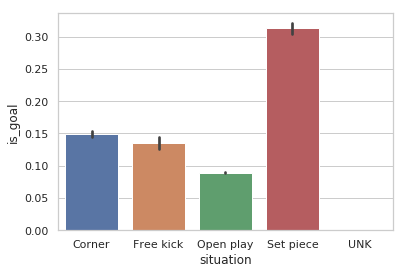

In [53]:
sit_plt = sns.barplot(df_feats.situation, df_feats.is_goal);
sit_plt.figure.savefig('../figures/sit_plt.pdf', format='pdf')

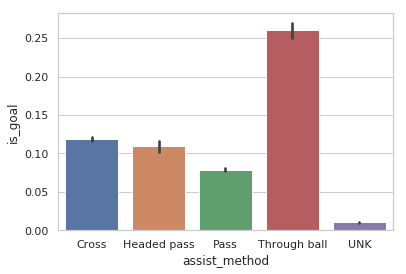

In [54]:
assist_plt = sns.barplot(df_feats.assist_method, df_feats.is_goal);
assist_plt.figure.savefig('../figures/assist_plt.pdf', format='pdf')

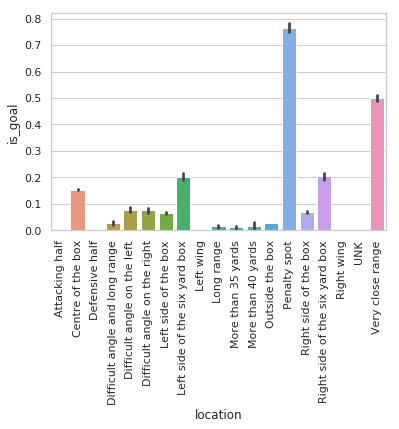

In [63]:
ax = sns.barplot(df_feats.location, df_feats.is_goal );
plt.xticks(rotation=90);
ax.figure.savefig('../figures/location_plt.pdf', format='pdf', bbox_inches="tight")

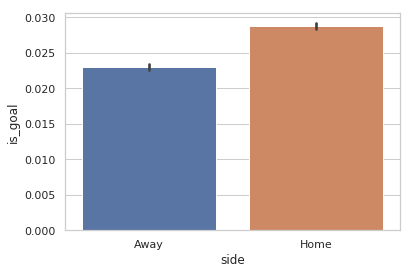

In [56]:
side_plt = sns.barplot(df_feats.side, df_feats.is_goal);
side_plt.figure.savefig('../figures/side_plt.pdf', format='pdf')

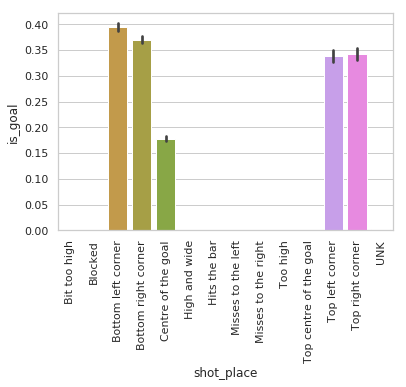

In [62]:
shot_place = sns.barplot(df_feats.shot_place, df_feats.is_goal);
plt.xticks(rotation=90);
shot_place.figure.savefig('../figures/shot_place.pdf', format='pdf', bbox_inches="tight")

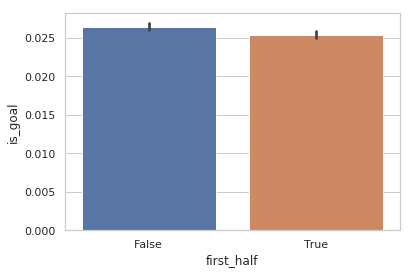

In [58]:
first_half_plt = sns.barplot(df_feats.first_half, df_feats.is_goal);
first_half_plt.figure.savefig('../figures/first_half_plt.pdf', format='pdf')

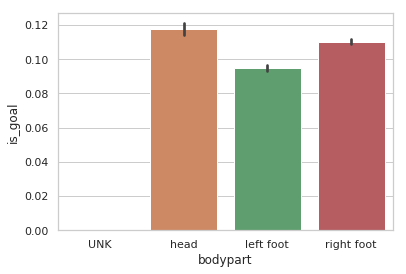

In [59]:
bodypart_plt = sns.barplot(df_feats.bodypart, df_feats.is_goal);
bodypart_plt.figure.savefig('../figures/bodypart_plt.pdf', format='pdf')

In [26]:
df_feats.groupby(['bodypart', 'is_goal'], sort=False).size().reset_index(name='Count')

,bodypart,is_goal,Count
0,left foot,False,64532
1,UNK,False,711823
2,right foot,False,108488
3,left foot,True,6758
4,head,False,31720
5,right foot,True,13451
6,head,True,4236
7,UNK,True,1


# Without handling class imbalance

## Logistic Regression

In [25]:
x_train, x_val, y_train, y_val = train_test_split(pd.get_dummies(df_feats.drop(['is_goal'], axis=1)),
                                                  df_feats.is_goal.values,
                                                  test_size = .1,
                                                  random_state=12)
print('Number of features after one-hot encoding: ', len(pd.get_dummies(df_feats.drop(['is_goal'], axis=1))))

model = LogisticRegression()
model.fit(x_train, y_train)

# make predictions
expected = y_val
predicted = model.predict(x_val)

print('Accuracy: ', metrics.accuracy_score(expected, predicted))
print('Balanced Acc: ', metrics.balanced_accuracy_score(expected, predicted))

Number of features after one-hot encoding:  941009
Accuracy:  0.9841659493522917
Balanced Acc:  0.8037608442451609


## Gradient Boosting model

In [104]:

# Create the model
gradient_boosted = GradientBoostingClassifier()

# Fit the model on the training data
gradient_boosted.fit(x_train, y_train)

# Make predictions on the test data
predictions = gradient_boosted.predict(x_val)

# summarize the fit of the model
print(metrics.classification_report(y_val, predictions))
print(metrics.confusion_matrix(y_val, predictions))

# Evaluate the model
print('Accuracy: ', metrics.accuracy_score(y_val, predictions))
print('Balanced Acc: ', metrics.balanced_accuracy_score(y_val, predictions))

              precision    recall  f1-score   support

       False       0.99      1.00      0.99     91631
        True       0.80      0.52      0.63      2470

   micro avg       0.98      0.98      0.98     94101
   macro avg       0.89      0.76      0.81     94101
weighted avg       0.98      0.98      0.98     94101

[[91306   325]
 [ 1188  1282]]
Accuracy:  0.983921531120817
Balanced Acc:  0.7577407527472118


## Support Vector Machine

In [ ]:
# # Create the model
# svm = SVC()

# # Fit the model on the training data
# svm.fit(x_train, y_train)

# # Make predictions on the test data
# predictions = svm.predict(x_val)

# # summarize the fit of the model
# print(metrics.classification_report(y_val, predictions))
# print(metrics.confusion_matrix(y_val, predictions))

# # Evaluate the model
# print('Accuracy: ', metrics.accuracy_score(y_val, predictions))
# print('Balanced Acc: ', metrics.balanced_accuracy_score(y_val, predictions))

## Random Forest

In [52]:
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    ax.figure.savefig('../figures/feats_imp.pdf', format='pdf', bbox_inches="tight")
    
    return df

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   21.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


              precision    recall  f1-score   support

       False       0.99      0.99      0.99     91631
        True       0.69      0.57      0.62      2470

   micro avg       0.98      0.98      0.98     94101
   macro avg       0.84      0.78      0.81     94101
weighted avg       0.98      0.98      0.98     94101

[[91003   628]
 [ 1066  1404]]
Accuracy:  0.9819980659079075
Balanced Acc:  0.7807837384383245


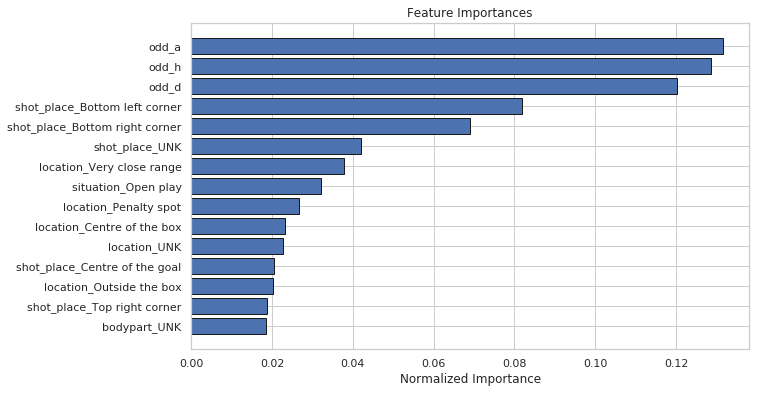

In [35]:
# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 12, verbose = 1, n_jobs = -1)
# Train on the training data
random_forest.fit(x_train, y_train);
df_feats_dumm = pd.get_dummies(df_feats.drop(['is_goal'], axis=1))
# Feature names
features = list(df_feats_dumm.columns)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict(x_val)

# summarize the fit of the model
print(metrics.classification_report(y_val, predictions))
print(metrics.confusion_matrix(y_val, predictions))

print('Accuracy: ', metrics.accuracy_score(y_val, predictions))
print('Balanced Acc: ', metrics.balanced_accuracy_score(y_val, predictions))

# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

# Handling imbalance classes: Random Under Sampling

we have class imbalance, we will use evaluation metrics different from accuracy which include (True positive, True negative, False positive, False negative)

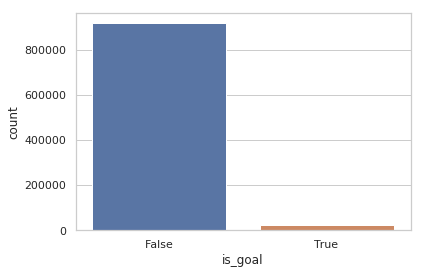

In [66]:
class_imb = sns.countplot(df_feats.is_goal)
class_imb.figure.savefig('../figures/class_imb.pdf', format = 'pdf')

In [36]:
print('Original dataset shape %s' % Counter(y_train))

Original dataset shape Counter({False: 824932, True: 21976})


In [37]:
rus = RandomUnderSampler(random_state=42)
X_res_u, y_res_u = rus.fit_resample(x_train, y_train)

In [38]:
print('Resampled dataset shape %s' % Counter(y_res_u))

Resampled dataset shape Counter({False: 21976, True: 21976})


## Logistic Regression model

In [39]:
model = LogisticRegression()
model.fit(X_res_u, y_res_u)

print(model)

# make predictions
expected = y_val
predicted = model.predict(x_val)

# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

print('Accuracy: ', metrics.accuracy_score(expected, predicted))
print('Balanced Acc: ', metrics.balanced_accuracy_score(expected, predicted))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
              precision    recall  f1-score   support

       False       1.00      0.94      0.97     91631
        True       0.32      1.00      0.49      2470

   micro avg       0.95      0.95      0.95     94101
   macro avg       0.66      0.97      0.73     94101
weighted avg       0.98      0.95      0.96     94101

[[86464  5167]
 [    0  2470]]
Accuracy:  0.945090912955229
Balanced Acc:  0.971805393371239


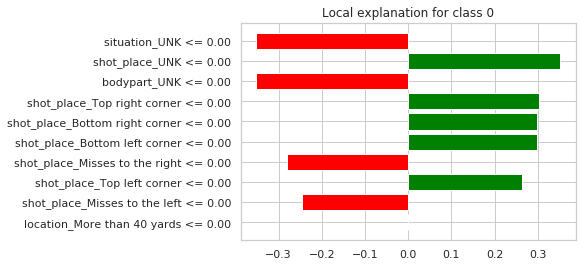

In [46]:
# Find the residuals
pred = predicted.astype('int8')
# y = y_val.as_matrix().astype('int8')
residuals = abs(pred - y_val)
x = x_val.as_matrix()
# Extract the most wrong prediction
wrong = x[np.argmax(residuals), :]

# Create a lime explainer object
explainer = lime_tabular.LimeTabularExplainer(training_data = X_res_u, 
                                                   mode = 'classification',
                                                   training_labels = y_res_u,
                                                   feature_names = df_feats_dumm.columns.tolist())

# Explanation for wrong prediction
exp = explainer.explain_instance(data_row = wrong, 
                                     predict_fn = model.predict_proba, labels=(0,1))

# Plot the prediction explaination
exp.as_pyplot_figure(label=0,);


## Gradient Boosting model

In [47]:

# Create the model
gradient_boosted = GradientBoostingClassifier()

# Fit the model on the training data
gradient_boosted.fit(X_res_u, y_res_u)

# Make predictions on the test data
predictions = gradient_boosted.predict(x_val)

# summarize the fit of the model
print(metrics.classification_report(y_val, predictions))
print(metrics.confusion_matrix(y_val, predictions))

# Evaluate the model
print('Accuracy: ', metrics.accuracy_score(y_val, predictions))
print('Balanced Acc: ', metrics.balanced_accuracy_score(y_val, predictions))

              precision    recall  f1-score   support

       False       1.00      0.94      0.97     91631
        True       0.32      1.00      0.49      2470

   micro avg       0.94      0.94      0.94     94101
   macro avg       0.66      0.97      0.73     94101
weighted avg       0.98      0.94      0.96     94101

[[86439  5192]
 [    1  2469]]
Accuracy:  0.9448146140848662
Balanced Acc:  0.9714665475065742


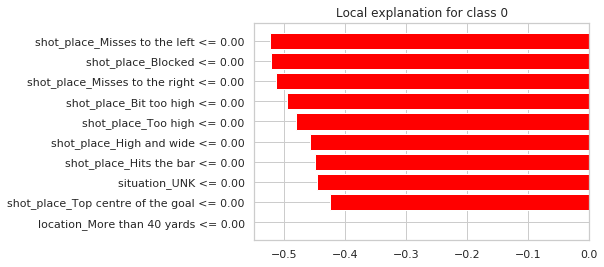

In [48]:
# Find the residuals
pred = predicted.astype('int8')
# y = y_val.as_matrix().astype('int8')
residuals = abs(pred - y_val)
x = x_val.as_matrix()
# Extract the most wrong prediction
wrong = x[np.argmax(residuals), :]

# Create a lime explainer object
explainer = lime_tabular.LimeTabularExplainer(training_data = X_res_u, 
                                                   mode = 'classification',
                                                   training_labels = y_res_u,
                                                   feature_names = df_feats_dumm.columns.tolist())

# Explanation for wrong prediction
exp = explainer.explain_instance(data_row = wrong, 
                                     predict_fn = gradient_boosted.predict_proba, labels=(0,1))

# Plot the prediction explaination
exp.as_pyplot_figure(label=0,);


## Support Vector Machine

In [202]:


# Create the model
svm = SVC()

# Fit the model on the training data
svm.fit(X_res_u, y_res_u)

# Make predictions on the test data
predictions = svm.predict(x_val)

# summarize the fit of the model
print(metrics.classification_report(y_val, predictions))
print(metrics.confusion_matrix(y_val, predictions))

# Evaluate the model
print('Accuracy: ', metrics.accuracy_score(y_val, predictions))
print('Balanced Acc: ', metrics.balanced_accuracy_score(y_val, predictions))

              precision    recall  f1-score   support

       False       1.00      0.94      0.97     91631
        True       0.31      1.00      0.47      2470

   micro avg       0.94      0.94      0.94     94101
   macro avg       0.65      0.97      0.72     94101
weighted avg       0.98      0.94      0.96     94101

[[86012  5619]
 [    0  2470]]
Accuracy:  0.9402875633627698
Balanced Acc:  0.9693389791664393


## Random Forest

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


              precision    recall  f1-score   support

       False       1.00      0.95      0.97     91631
        True       0.35      0.99      0.52      2470

   micro avg       0.95      0.95      0.95     94101
   macro avg       0.67      0.97      0.75     94101
weighted avg       0.98      0.95      0.96     94101

[[87087  4544]
 [   25  2445]]
Accuracy:  0.951445786973571
Balanced Acc:  0.9701441691607913


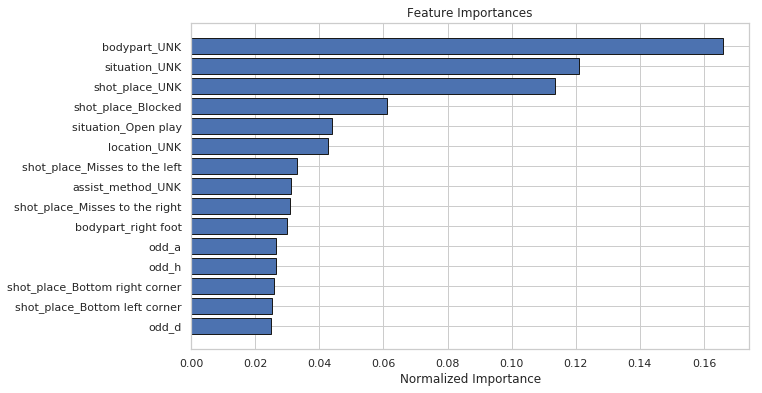

In [53]:


# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 12, verbose = 1, n_jobs = -1)
# Train on the training data
random_forest.fit(X_res_u, y_res_u);

# Feature names
features = list(df_feats_dumm.columns)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict(x_val)

# summarize the fit of the model
print(metrics.classification_report(y_val, predictions))
print(metrics.confusion_matrix(y_val, predictions))

print('Accuracy: ', metrics.accuracy_score(y_val, predictions))
print('Balanced Acc: ', metrics.balanced_accuracy_score(y_val, predictions))

# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

# Remove null vals

## 2nd Trial: SMOTENC

Using the same manually chosen features

In [67]:
feat_cols

['odd_h',
 'odd_d',
 'odd_a',
 'assist_method',
 'location',
 'side',
 'shot_place',
 'situation',
 'bodypart',
 'time',
 'is_goal']

In [69]:
df = read_merge()

# Fix the datatypes of some categorical columns
categoricals = ['id_odsp', 'event_type', 'event_team', 'opponent', 'shot_place', 'shot_outcome', 'location', 'bodypart', 'assist_method', 'situation', 'side', 'player']
df = fix_dtypes(df, categoricals)


# Drop NA values
df_feats = select_feats(df, feat_cols)
df_feats['first_half'] = df_feats.time <= 45
df_feats.first_half = df_feats.first_half.astype('bool')
df_feats.drop(['time'], axis = 1, inplace =True)


df_feats.dropna(inplace=True)
df_feats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167141 entries, 0 to 941006
Data columns (total 11 columns):
odd_h            167141 non-null float16
odd_d            167141 non-null float16
odd_a            167141 non-null float16
assist_method    167141 non-null category
location         167141 non-null category
side             167141 non-null category
shot_place       167141 non-null category
situation        167141 non-null category
bodypart         167141 non-null category
is_goal          167141 non-null bool
first_half       167141 non-null bool
dtypes: bool(2), category(6), float16(3)
memory usage: 3.5 MB


In [71]:
x_train, x_val, y_train, y_val = train_test_split(pd.get_dummies(df_feats.drop(['is_goal'], axis=1)),
                                                  df_feats.is_goal.values,
                                                  test_size = .1,
                                                  random_state=12)


print('Original dataset shape %s' % Counter(y_train))

Original dataset shape Counter({False: 136239, True: 14187})


In [72]:
x_train.iloc[0,1]
num_feats = len(x_train.columns)
x_train.head()
cat_indices = np.arange(3, num_feats)
cat_indices

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

In [73]:
res_smote = SMOTENC(categorical_features= cat_indices, random_state=42)
X_res, y_res = res_smote.fit_resample(x_train, y_train)

In [76]:
# save SMOTE resampled dataset after removing the null values
df_feats_dumm = pd.get_dummies(df_feats.drop(['is_goal'], axis=1))
df_X_smote = pd.DataFrame(X_res, columns=df_feats_dumm.columns)
df_y_smote = pd.DataFrame(y_res, columns=['is_goal'])
df_X_smote.to_csv('../data/X_res_SMOTE.csv')
df_y_smote.to_csv('../data/y_res_SMOTE.csv')

In [77]:
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({False: 136239, True: 136239})


## Logistic Regression model

In [78]:
model = LogisticRegression()
model.fit(X_res, y_res)

# make predictions
expected = y_val
predicted = model.predict(x_val)

# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

print('Accuracy: ', metrics.accuracy_score(expected, predicted))
print('Balanced Acc: ', metrics.balanced_accuracy_score(expected, predicted))

              precision    recall  f1-score   support

       False       0.99      0.82      0.90     15055
        True       0.37      0.95      0.54      1660

   micro avg       0.84      0.84      0.84     16715
   macro avg       0.68      0.89      0.72     16715
weighted avg       0.93      0.84      0.86     16715

[[12405  2650]
 [   77  1583]]
Accuracy:  0.8368531259347891
Balanced Acc:  0.8887966012172236


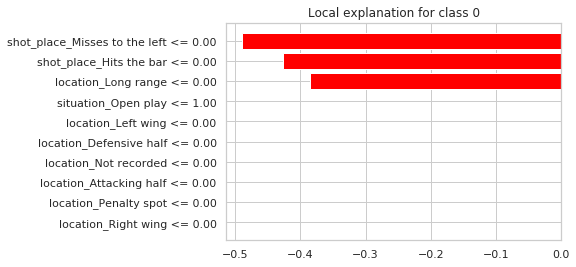

In [80]:
# Find the residuals
pred = predicted.astype('int8')
# y = y_val.as_matrix().astype('int8')
residuals = abs(pred - y_val)
x = x_val.as_matrix()
# Extract the most wrong prediction
wrong = x[np.argmax(residuals), :]

# Create a lime explainer object
explainer = lime_tabular.LimeTabularExplainer(training_data = X_res, 
                                                   mode = 'classification',
                                                   training_labels = y_res,
                                                   feature_names = df_feats_dumm.columns.tolist())

# Explanation for wrong prediction
exp = explainer.explain_instance(data_row = wrong, 
                                     predict_fn = model.predict_proba, labels=(0,1))

# Plot the prediction explaination
exp.as_pyplot_figure(label=0,);


## Gradient Boosting model

In [81]:

# Create the model
gradient_boosted = GradientBoostingClassifier()

# Fit the model on the training data
gradient_boosted.fit(X_res, y_res)

# Make predictions on the test data
predictions = gradient_boosted.predict(x_val)

# summarize the fit of the model
print(metrics.classification_report(y_val, predictions))
print(metrics.confusion_matrix(y_val, predictions))

# Evaluate the model
print('Accuracy: ', metrics.accuracy_score(y_val, predictions))
print('Balanced Acc: ', metrics.balanced_accuracy_score(y_val, predictions))

              precision    recall  f1-score   support

       False       1.00      0.79      0.88     15055
        True       0.34      0.98      0.51      1660

   micro avg       0.81      0.81      0.81     16715
   macro avg       0.67      0.89      0.69     16715
weighted avg       0.93      0.81      0.84     16715

[[11904  3151]
 [   31  1629]]
Accuracy:  0.8096320670056835
Balanced Acc:  0.8860130325353224


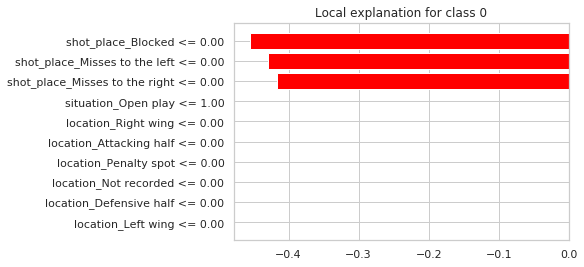

In [83]:
# Find the residuals
pred = predicted.astype('int8')
# y = y_val.as_matrix().astype('int8')
residuals = abs(pred - y_val)
x = x_val.as_matrix()
# Extract the most wrong prediction
wrong = x[np.argmax(residuals), :]

# Create a lime explainer object
explainer = lime_tabular.LimeTabularExplainer(training_data = X_res, 
                                                   mode = 'classification',
                                                   training_labels = y_res,
                                                   feature_names = df_feats_dumm.columns.tolist())

# Explanation for wrong prediction
exp = explainer.explain_instance(data_row = wrong, 
                                     predict_fn = gradient_boosted.predict_proba, labels=(0,1))

# Plot the prediction explaination
exp.as_pyplot_figure(label=0,);


## Random Forest

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s


              precision    recall  f1-score   support

       False       0.96      0.91      0.94     15055
        True       0.47      0.69      0.56      1660

   micro avg       0.89      0.89      0.89     16715
   macro avg       0.72      0.80      0.75     16715
weighted avg       0.91      0.89      0.90     16715

[[13773  1282]
 [  520  1140]]
Accuracy:  0.8921926413401137
Balanced Acc:  0.8007962771044324


[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


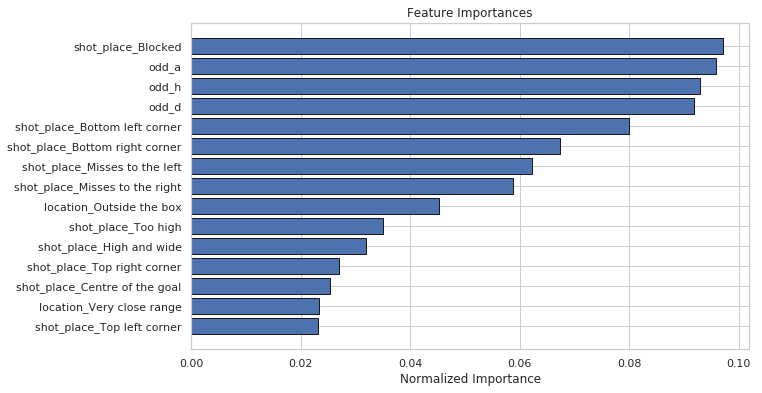

In [84]:
# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 12, verbose = 1, n_jobs = -1)
# Train on the training data
random_forest.fit(X_res, y_res);

# Feature names
features = list(df_feats_dumm.columns)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict(x_val)

# summarize the fit of the model
print(metrics.classification_report(y_val, predictions))
print(metrics.confusion_matrix(y_val, predictions))

print('Accuracy: ', metrics.accuracy_score(y_val, predictions))
print('Balanced Acc: ', metrics.balanced_accuracy_score(y_val, predictions))

# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

## Handling imbalance classes: Random Over Sampling

In [ ]:
df_feats.dropna(inplace = True)
df_feats.info()

In [ ]:
training_features = df_feats.drop(columns=['is_goal'])
training_target = df_feats.is_goal

we have class imbalance, we will use evaluation metrics different from accuracy which include (True positive, True negative, False positive, False negative)

In [ ]:
# One-hot encoding for categorical columns
df_feats_dumm = pd.get_dummies(df_feats.drop(['is_goal'], axis=1))

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(df_feats_dumm, training_target,
                                                  test_size = .1,
                                                  random_state=12)


In [85]:
x_train.shape

(150426, 49)

In [86]:
x_val.shape

(16715, 49)

In [ ]:
# distribution of the response variable
df_feats.is_goal.astype('int').hist();

In [87]:
print('Original dataset shape %s' % Counter(y_train))

Original dataset shape Counter({False: 136239, True: 14187})


In [88]:
rus = RandomOverSampler(random_state=42)
X_res_o, y_res_o = rus.fit_resample(x_train, y_train)

In [89]:
print('Resampled dataset shape %s' % Counter(y_res_o))

Resampled dataset shape Counter({False: 136239, True: 136239})


## Logistic Regression model

In [125]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_res_o, y_res_o)

print(model)

# make predictions
expected = y_val
predicted = model.predict(x_val)

# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

print('Accuracy: ', metrics.accuracy_score(expected, predicted))
print('Balanced Acc: ', metrics.balanced_accuracy_score(expected, predicted))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
              precision    recall  f1-score   support

       False       1.00      0.82      0.90     15055
        True       0.37      0.97      0.53      1660

   micro avg       0.83      0.83      0.83     16715
   macro avg       0.68      0.89      0.71     16715
weighted avg       0.93      0.83      0.86     16715

[[12283  2772]
 [   50  1610]]
Accuracy:  0.8311696081364044
Balanced Acc:  0.8928773213078152


In [130]:
# Find the residuals
pred = predicted.astype('int8')
pred[4]

# y = y_val.as_matrix().astype('int8')
residuals = abs(pred - y_val)
x = x_val.as_matrix()
# Extract the most wrong prediction
wrong = x[np.argmax(residuals), :]
y_val[np.argmax(residuals)] 
pred[np.argmax(residuals)]
# # Create a lime explainer object
# explainer = lime_tabular.LimeTabularExplainer(training_data = X_res_o, 
#                                                    mode = 'classification',
#                                                    training_labels = y_res_o,
#                                                    feature_names = df_feats_dumm.columns.tolist())

# # Explanation for wrong prediction
# exp = explainer.explain_instance(data_row = wrong, 
#                                      predict_fn = model.predict_proba, labels=(0,1))

# # Plot the prediction explaination
# exp.as_pyplot_figure(label=0,);


1

## Gradient Boosting model

In [106]:

# Create the model
gradient_boosted = GradientBoostingClassifier()

# Fit the model on the training data
gradient_boosted.fit(X_res_o, y_res_o)

# Make predictions on the test data
predictions = gradient_boosted.predict(x_val)

# summarize the fit of the model
print(metrics.classification_report(y_val, predictions))
print(metrics.confusion_matrix(y_val, predictions))

# Evaluate the model
print('Accuracy: ', metrics.accuracy_score(y_val, predictions))
print('Balanced Acc: ', metrics.balanced_accuracy_score(y_val, predictions))

              precision    recall  f1-score   support

       False       1.00      0.80      0.88     15055
        True       0.35      0.98      0.51      1660

   micro avg       0.81      0.81      0.81     16715
   macro avg       0.67      0.89      0.70     16715
weighted avg       0.93      0.81      0.85     16715

[[11971  3084]
 [   31  1629]]
Accuracy:  0.8136404427161232
Balanced Acc:  0.8882382068959997


In [124]:
# Find the residuals
predictions = predictions.astype('int8')
# y = y_val.as_matrix().astype('int8')
residuals = abs(predictions - y_val)

residuals
x = x_val.as_matrix()

# Extract the most wrong prediction
wrong = x[np.argmax(residuals), :]


y_val[4]

# # Create a lime explainer object
# explainer = lime_tabular.LimeTabularExplainer(training_data = X_res_o, 
#                                                    mode = 'classification',
#                                                    training_labels = y_res_o,
#                                                    feature_names = df_feats_dumm.columns.tolist())

# # Explanation for wrong prediction
# exp = explainer.explain_instance(data_row = wrong, 
#                                      predict_fn = gradient_boosted.predict_proba, labels=(0,1))

# # Plot the prediction explaination
# exp.as_pyplot_figure(label=0,);


False

## Random Forest

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.8s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


              precision    recall  f1-score   support

       False       0.95      0.95      0.95     15055
        True       0.54      0.56      0.55      1660

   micro avg       0.91      0.91      0.91     16715
   macro avg       0.75      0.75      0.75     16715
weighted avg       0.91      0.91      0.91     16715

[[14271   784]
 [  735   925]]
Accuracy:  0.9091235417289859
Balanced Acc:  0.7525765966556361


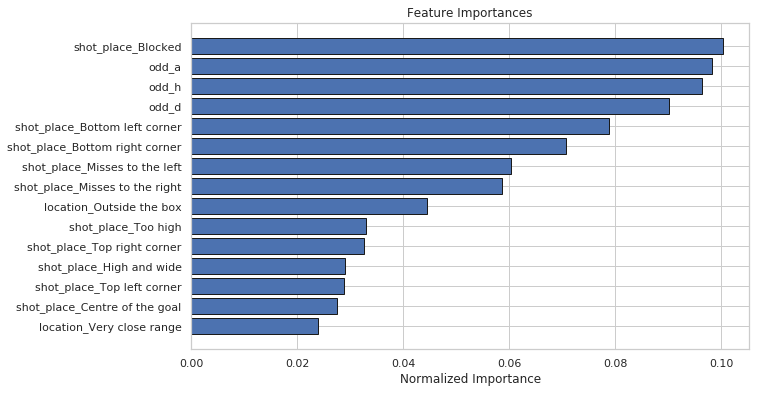

In [94]:
# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 12, verbose = 1, n_jobs = -1)
# Train on the training data
random_forest.fit(X_res_o, y_res_o);

# Feature names
features = list(df_feats_dumm.columns)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict(x_val)

# summarize the fit of the model
print(metrics.classification_report(y_val, predictions))
print(metrics.confusion_matrix(y_val, predictions))

print('Accuracy: ', metrics.accuracy_score(y_val, predictions))
print('Balanced Acc: ', metrics.balanced_accuracy_score(y_val, predictions))

# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

# Trial #4 Filling null values with 'UNK' and using SMOTENC

In [136]:
from imblearn.over_sampling import SMOTENC
from collections import Counter 

In [137]:
print('Original dataset shape %s' % Counter(y_train))

Original dataset shape Counter({False: 824932, True: 21976})


In [142]:
x_train.iloc[0,1]
num_feats = len(x_train.columns)
x_train.head()
cat_indices = np.arange(3, num_feats)
cat_indices

array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51])

In [143]:
# res_smote = SMOTENC(categorical_features= cat_indices, random_state=42)
# X_res, y_res = res_smote.fit_resample(x_train, y_train)

In [144]:
# save SMOTE resampled dataset after removing the null values
df_X_smote = pd.DataFrame(X_res, columns=df_feats_dumm.columns)
df_y_smote = pd.DataFrame(y_res, columns=['is_goal'])
df_X_smote.to_csv('../X_res_SMOTE_UNK.csv')
df_y_smote.to_csv('../y_res_SMOTE_UNK.csv')

In [145]:
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({False: 824932, True: 824932})


## Logistic Regression model

In [146]:
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_res, y_res)

# make predictions
expected = y_val
predicted = model.predict(x_val)

# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

print('Accuracy: ', metrics.accuracy_score(expected, predicted))
print('Balanced Acc: ', metrics.balanced_accuracy_score(expected, predicted))

              precision    recall  f1-score   support

       False       1.00      0.95      0.97     91631
        True       0.34      0.99      0.51      2470

   micro avg       0.95      0.95      0.95     94101
   macro avg       0.67      0.97      0.74     94101
weighted avg       0.98      0.95      0.96     94101

[[86870  4761]
 [   21  2449]]
Accuracy:  0.9491822616125227
Balanced Acc:  0.9697697886749339


## Random Forest

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   41.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


              precision    recall  f1-score   support

       False       0.99      0.98      0.99     91631
        True       0.49      0.79      0.61      2470

   micro avg       0.97      0.97      0.97     94101
   macro avg       0.74      0.88      0.80     94101
weighted avg       0.98      0.97      0.98     94101

[[89600  2031]
 [  514  1956]]
Accuracy:  0.9729545913433438
Balanced Acc:  0.8848689230882341


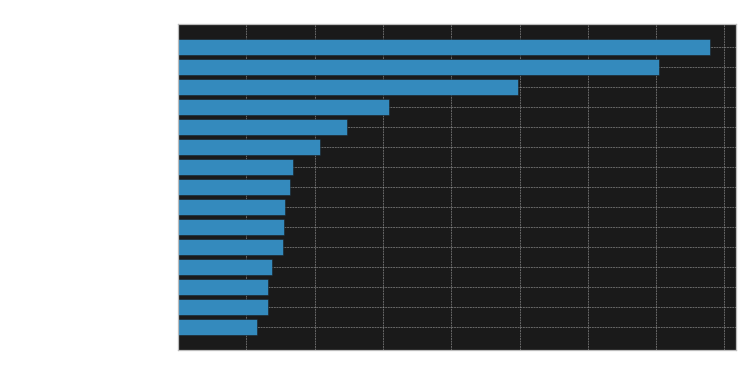

In [147]:
# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 12, verbose = 1, n_jobs = -1)
# Train on the training data
random_forest.fit(X_res, y_res);

# Feature names
features = list(df_feats_dumm.columns)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict(x_val)

# summarize the fit of the model
print(metrics.classification_report(y_val, predictions))
print(metrics.confusion_matrix(y_val, predictions))

print('Accuracy: ', metrics.accuracy_score(y_val, predictions))
print('Balanced Acc: ', metrics.balanced_accuracy_score(y_val, predictions))

# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

# 2 Odds



Odds are interpreted as the amount you will recieve back for every 1£ you bet on that result. For example, if the odds for a home win is 4, you will recieve 4£ for every 1£ you bet on a home win. Thus, from the perspective of the bookmaker, they would set a lower odd for the result they predict. The following function would return the bookmakers' predicted result of a match based on the highest odds for each result for a particular match.


In [95]:
df_game_info = pd.read_csv("../data/ginf.csv")

In [96]:
def odds_pred_result(odd_h,odd_d,odd_a):
    '''
    Predict game final result according to the odds for (home win, draw, and )
    Predict result of a match based on the highest odds for each result for a particular match
    '''
    if odd_h<odd_d and odd_h<odd_a:
        return("Home Win")
    elif odd_d<odd_h and odd_d<odd_a:
        return("Draw")
    elif odd_a<odd_d and odd_a<odd_h:
        return("Away Win")
    


# The next function would return the actual result of the match.
def actual_result(fthg,ftag):
    if fthg>ftag:
        return("Home Win")
    elif fthg==ftag:
        return("Draw")
    elif fthg<ftag:
        return("Away Win")
    
def actual_result_encode(fthg,ftag):
    if fthg>ftag:
        return (1)
    elif fthg==ftag:
        return (2)
    elif fthg<ftag:
        return (3)

In [97]:
# We now compare the chances of us predicting the result of the game correctly just by looking at the odds.
def check_pred(data):
    correct=0
    wrong=0
    for i in range(1,data.shape[0]+1):
        odd_h=data[i-1:i]["odd_h"].item()
        odd_d=data[i-1:i]["odd_d"].item()
        odd_a=data[i-1:i]["odd_a"].item()
        fthg=data[i-1:i]["fthg"].item()
        ftag=data[i-1:i]["ftag"].item()
        oddsresult=odds_pred_result(odd_h,odd_d,odd_a)
        actresult=actual_result(fthg,ftag)
        if oddsresult==actresult:
            correct+=1
        else:
            wrong+=1
    return(str("%.2f"%(correct/(correct+wrong)))+str("% correct"))

check_pred(df_game_info)

'0.53% correct'

## We will try to use the odds and the difference among the odds to predict the result of a match.


In [98]:
x_odds = df_game_info.iloc[:,9:14]
x_odds.head()

result=[]
for i in range(1, df_game_info.shape[0]+1):
    result.append(actual_result_encode(df_game_info[i-1:i]["fthg"].item(),
                                       df_game_info[i-1:i]["ftag"].item()))
y_result = pd.DataFrame(result)

x_odds["diff_h_d"] = abs(x_odds["odd_h"] - x_odds["odd_d"])
x_odds["diff_d_a"] = abs(x_odds["odd_d"] - x_odds["odd_a"])
x_odds["diff_h_a"] = abs(x_odds["odd_h"] - x_odds["odd_a"])
x_odds = x_odds.drop(["fthg","ftag"],axis=1)

x_odds.tail()
y_result.tail()

,0
10107,2
10108,1
10109,1
10110,2
10111,1


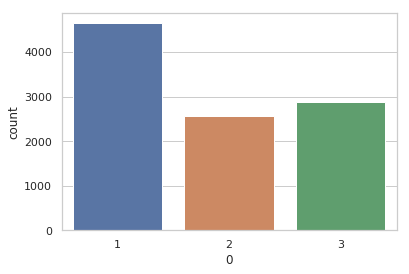

In [99]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

sns.countplot(y_result.iloc[:,0]);

In [100]:
x_odds_train, x_odds_test, y_odds_train, y_odds_test = train_test_split(x_odds, y_result, test_size=0.2,random_state=0)

# Logistic regression

from sklearn import metrics
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(x_odds_train, y_odds_train)

# make predictions
expected = y_odds_test
predicted = model.predict(x_odds_test)

# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

print('Accuracy: ', metrics.accuracy_score(expected, predicted))
print('Balanced Acc: ', metrics.balanced_accuracy_score(expected, predicted))

              precision    recall  f1-score   support

           1       0.54      0.89      0.67       925
           2       0.00      0.00      0.00       519
           3       0.56      0.50      0.53       579

   micro avg       0.55      0.55      0.55      2023
   macro avg       0.37      0.46      0.40      2023
weighted avg       0.41      0.55      0.46      2023

[[820   0 105]
 [396   0 123]
 [289   0 290]]
Accuracy:  0.5486900642609985
Balanced Acc:  0.462450014781621


## Gradient Boosting model

In [101]:

# Create the model
gradient_boosted = GradientBoostingClassifier()

# Fit the model on the training data
gradient_boosted.fit(x_odds_train, y_odds_train)

# Make predictions on the test data
predictions = gradient_boosted.predict(x_odds_test)

# summarize the fit of the model
print(metrics.classification_report(y_odds_test, predictions))
print(metrics.confusion_matrix(y_odds_test, predictions))

# Evaluate the model
print('Accuracy: ', metrics.accuracy_score(y_odds_test, predictions))
print('Balanced Acc: ', metrics.balanced_accuracy_score(y_odds_test, predictions))

              precision    recall  f1-score   support

           1       0.56      0.82      0.67       925
           2       0.27      0.05      0.08       519
           3       0.54      0.53      0.53       579

   micro avg       0.54      0.54      0.54      2023
   macro avg       0.46      0.47      0.43      2023
weighted avg       0.48      0.54      0.48      2023

[[763  36 126]
 [352  25 142]
 [239  31 309]]
Accuracy:  0.5422639644092931
Balanced Acc:  0.4689043927272086


## Random Forest

In [104]:
# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 12, verbose = 1, n_jobs = -1)
# Train on the training data
random_forest.fit(x_odds_train, y_odds_train);

# Feature names
features = list(df_feats_dumm.columns)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
# feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict(x_odds_test)

# summarize the fit of the model
print(metrics.classification_report(y_odds_test, predictions))
print(metrics.confusion_matrix(y_odds_test, predictions))

print('Accuracy: ', metrics.accuracy_score(y_odds_test, predictions))
print('Balanced Acc: ', metrics.balanced_accuracy_score(y_odds_test, predictions))

# Show the feature importances for the default features
# feature_importances_sorted = plot_feature_importances(feature_importances)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


              precision    recall  f1-score   support

           1       0.56      0.65      0.60       925
           2       0.28      0.21      0.24       519
           3       0.46      0.44      0.45       579

   micro avg       0.48      0.48      0.48      2023
   macro avg       0.43      0.43      0.43      2023
weighted avg       0.46      0.48      0.47      2023

[[605 165 155]
 [271 110 138]
 [205 120 254]]
Accuracy:  0.4789915966386555
Balanced Acc:  0.4348958320685536
